In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_train = pd.read_csv('./new_csv/train.csv')
data_test = pd.read_csv('./new_csv/test_noLabel.csv')
data = pd.concat([data_train,data_test],axis = 0)

In [2]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV

In [3]:
data.isnull().sum()
data.EmployeeNumber.value_counts()

2046    1
643     1
645     1
647     1
648     1
       ..
1364    1
1367    1
1368    1
1369    1
2048    1
Name: EmployeeNumber, Length: 1450, dtype: int64

In [18]:
drop_cols = ["ID","EmployeeNumber", "Over18", "StandardHours", "JobLevel"]
cols = []
for co in data.columns:
    if co not in drop_cols:
        cols.append(co)
len(cols)

25

In [5]:
#plt.figure(figsize = (14,12))
#sns.heatmap(data=train[cols].corr())
#plt.show()

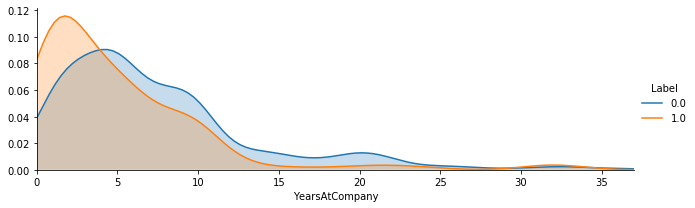

In [6]:
facet = sns.FacetGrid(data,hue = 'Label' ,aspect=3)
facet.map(sns.kdeplot,'YearsAtCompany',shade = True)
facet.set(xlim=(0,data['YearsAtCompany'].max()))
facet.add_legend()

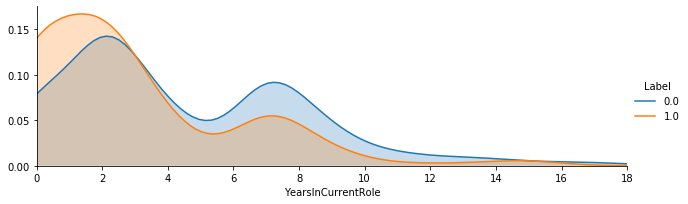

In [7]:
facet = sns.FacetGrid(data,hue = 'Label' ,aspect=3)
facet.map(sns.kdeplot,'YearsInCurrentRole',shade = True)
facet.set(xlim=(0,data['YearsInCurrentRole'].max()))
facet.add_legend()

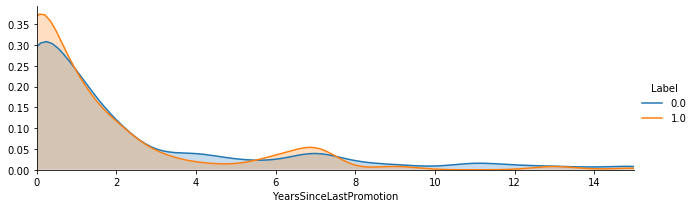

In [8]:
facet = sns.FacetGrid(data,hue = 'Label' ,aspect=3)
facet.map(sns.kdeplot,'YearsSinceLastPromotion',shade = True)
facet.set(xlim=(0,data['YearsSinceLastPromotion'].max()))
facet.add_legend()

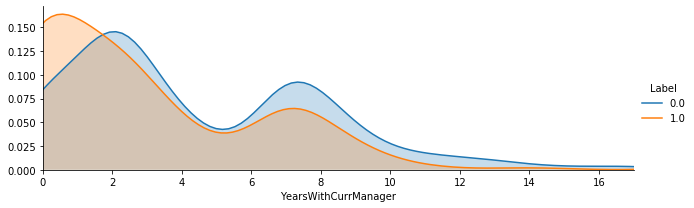

In [9]:
facet = sns.FacetGrid(data,hue = 'Label' ,aspect=3)
facet.map(sns.kdeplot,'YearsWithCurrManager',shade = True)
facet.set(xlim=(0,data['YearsWithCurrManager'].max()))
facet.add_legend()

In [10]:
#data['YearValue'] = data['YearsAtCompany'] + data['YearsInCurrentRole'] * 2 + data['YearsSinceLastPromotion'] * 2 + data['YearsWithCurrManager'] * 2
#data.drop(columns=["YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"], inplace=True)

In [11]:
data.drop(columns=drop_cols, inplace=True)

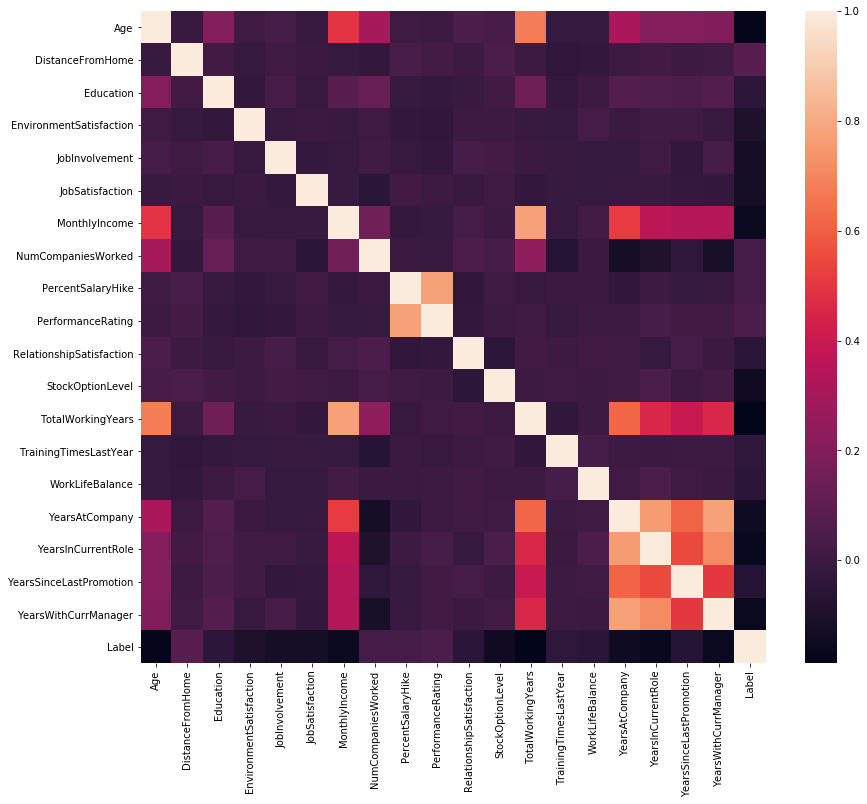

In [12]:
plt.figure(figsize = (14,12))
sns.heatmap(data=data.corr())
plt.show()

In [13]:
data["Satisfaction"] = data['JobSatisfaction'] + data['EnvironmentSatisfaction'] + data['RelationshipSatisfaction']
data.drop(columns=["JobSatisfaction", "EnvironmentSatisfaction", "RelationshipSatisfaction"], inplace=True)

In [14]:
#年龄处理
def resetAge(name):
    if (name < 22) & (name > 18) & (name == 58):
        return 1
    elif (name == 18) & (name == 48) & (name == 54) & (name == 57) & (name > 58) :
        return 0
    else:
        return 2
#薪资处理
def resetSalary(s):
    if s>0 & s<3725:
        return 0
    elif s>=3725 & s<11250:
        return 1
    else:
        return 2
#工资提高比例
def resetPerHike(s):
    if s >= 24 & s < 25:
        return 0
    elif (s >= 11 & s < 14) | (s > 14 & s < 22):
        return 1
    else:
        return 2
data['PercentSalaryHike'] = data['PercentSalaryHike'].apply(resetPerHike)
data['MonthlyIncome'] = data['MonthlyIncome'].apply(resetSalary)
data['Age'] = data['Age'].apply(resetAge) 

In [15]:
pd.get_dummies(data)

,Age,DistanceFromHome,Education,JobInvolvement,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,2,1,4,2,0,1,0,3,1,7,...,1,0,0,0,0,1,0,0,1,0
1,2,1,4,3,0,7,0,3,1,33,...,1,0,0,0,0,1,0,0,1,0
2,2,7,3,1,0,1,0,4,0,9,...,0,0,0,0,0,0,0,1,0,1
3,2,1,1,2,0,1,0,3,1,21,...,1,0,0,0,0,0,1,0,1,0
4,2,1,3,2,0,1,0,3,2,1,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,2,10,4,3,0,1,0,3,1,5,...,0,0,0,1,0,1,0,0,0,1
346,2,3,2,4,0,6,0,4,1,13,...,0,0,0,0,0,1,0,0,1,0
347,2,1,3,1,0,3,0,4,2,7,...,0,0,0,0,0,0,1,0,1,0
348,2,7,3,3,0,1,0,3,1,6,...,0,0,0,0,0,0,1,0,0,1


In [39]:
from sklearn.feature_selection import RFE

sep = 1100
y = pd.get_dummies(data).iloc[0:sep,:]['Label']
X = pd.get_dummies(data).iloc[0:sep,:].drop('Label',axis = 1)
models = []

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
model = linear_model.LogisticRegression(solver="liblinear", penalty="l2", C=2.4, max_iter=3000)
model.fit(X_train, y_train)
#rfe
rfe = RFE(logreg, 18)
rfe = rfe.fit(X_train, y_train)
print(X_train.columns)
print(rfe.support_)
print(rfe.ranking_)
#scores
score = cross_val_score(model,X,y,cv=4,scoring='accuracy')
#print("LR:%.3f(%.3f)"%(score.mean(),score.std()))
pred = model.predict(X=X_test)
print(metrics.confusion_matrix(y_test, pred))
score = metrics.accuracy_score(y_test, pred)
score_true = metrics.recall_score(y_test, pred)
score_false = metrics.recall_score(y_test, pred, pos_label=0)
print("理论准确率：", model.score(X_train, y_train))
print("实际准确率:", score)
print("正例覆盖率：", score_true)
print("负例覆盖率：", score_false)
models.append(model)

Index(['Age', 'DistanceFromHome', 'Education', 'JobInvolvement',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Satisfaction', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research D

In [17]:
target = pd.read_csv('./new_csv/submit_example.csv')
result = models[0].predict(X=pd.get_dummies(data).iloc[sep:,:].drop('Label',axis = 1))
target['Label'] = pd.DataFrame({'Label':result})
target.to_csv("./new_csv/submit_example.csv", index=False, sep=',')